In [1]:
from ml.models import cat_dog_classifier

from tqdm import tqdm

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib as mpl
import matplotlib.pyplot as plt

## TODO: 데이터 준비하기

공유된 data.zip을 풀어 최상위 폴더 안에 `data/` 폴더가 오도록 합니다. 다음과 같은 폴더 구조를 갖습니다.

```
data/
|-- cat/
    |-- cat.0.jpg
    |-- cat.1.jpg
    |-- cat.2.jpg
    |-- ...
|-- dog/
    |-- dog.0.jpg
    |-- dog.1.jpg
    |-- dog.2.jpg
    |-- ...
```

data.zip은 [캐글 강아지 vs 고양지 분류 대회](https://www.kaggle.com/competitions/dogs-vs-cats/data)의 train 데이터를 위 형태로 처리하여 준비했습니다.

## 데이터 불러오기

In [2]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
])

In [3]:
dataset = ImageFolder("data", transform=transform)

In [4]:
def visualize_sample(sample):
    print("Class is:", sample[1])
    plt.imshow(sample[0].transpose(0, 1).transpose(1, 2))

Class is: 0


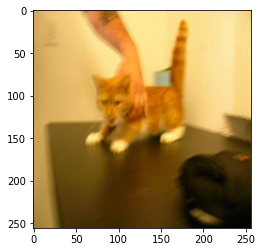

In [5]:
visualize_sample(dataset[0])

Class is: 0


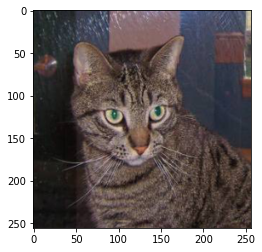

In [6]:
visualize_sample(dataset[1])

Class is: 1


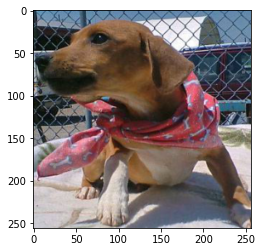

In [7]:
visualize_sample(dataset[20000])

## 검증을 위한 데이터 분할

In [8]:
train_length = round(len(dataset) * 0.7)
val_length = len(dataset) - train_length
train, val = random_split(dataset, [train_length, val_length])

Class is: 0


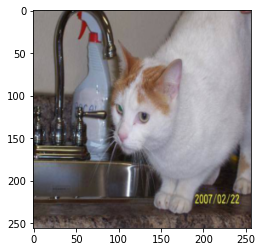

In [9]:
visualize_sample(train[0])

Class is: 0


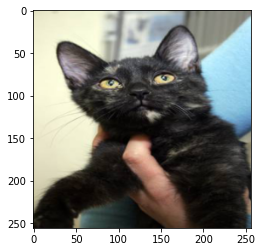

In [10]:
visualize_sample(val[0])

## 모델 학습 준비

In [11]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [12]:
model = cat_dog_classifier()
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001)

In [13]:
BATCH_SIZE = 32
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
model.to(device)
criterion.to(device)

CrossEntropyLoss()

## 모델 평가

In [ ]:
def get_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        total += y.shape[0]
        correct += (y == pred.argmax(1)).sum().item()
    return correct / total

In [ ]:
get_accuracy(model, val_loader)

## 모델 학습

In [ ]:
def train_epoch(model, loader):
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(loader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()

        total += y.shape[0]
        correct += (y == pred.argmax(1)).sum().item()
        total_loss += loss.item()

        optimizer.step()

    accuracy = correct / total
    average_loss = total_loss / len(loader)
    
    return accuracy, average_loss

In [ ]:
best_val_acc = 0
for epoch in range(2):
    
    print("Epoch {}".format(epoch + 1).center(40).center(80, "#"))
    train_acc, train_loss = train_epoch(model, train_loader)
    val_acc = get_accuracy(model, val_loader)
    
    print("train_acc={:.5f} train_loss={:.5f} val_acc={:.5f}".format(train_acc, train_loss, val_acc))
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pt")
        print("Saved model to `model.pt`")

## Sanity Test

In [24]:
torch.save(model.state_dict(), "model.pt")

In [25]:
model.load_state_dict(torch.load("model.pt", map_location="cpu"))

<All keys matched successfully>

In [26]:
model = model.to(device)

In [27]:
get_accuracy(model, val_loader)

NameError: name 'get_accuracy' is not defined

In [28]:
from PIL import Image

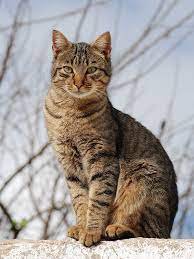

In [29]:
image = Image.open("test/test3.jpeg")
image

In [30]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 5.3838, -3.1633]], grad_fn=<AddmmBackward0>)


In [31]:
model.fc._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-3.9629e-02, -8.5385e-03,  3.3447e-03,  ...,  2.9277e-02,
                        3.2088e-02, -2.5352e-02],
                      [-5.5776e-05, -4.3962e-03, -1.6118e-03,  ..., -1.8999e-02,
                       -1.3788e-02, -5.4909e-03]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([0.0109, 0.0300], requires_grad=True))])

In [32]:
if prediction == 0:
    print("It's a cat")
else:
    print("It's a dog")

It's a cat
